# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Fall 2022

## Setup

You shouldn't have to change anything in these cells

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [3]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training - Lab 1 a

Train a model and save the checkpoint. This cell is used in Lab-1 (for Lab-3, please see a cell below)

In [ ]:
## Pick a model architecture
which_net = 'B'
test_acc_arr_lab1a = []

if which_net == 'A':
    net = models.NetA().to(device)
    ## Checkpoint name for this model
    model_checkpoint = "netA_standard.pt"
if which_net == 'B':
    net = models.NetB().to(device)
    model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    test_acc_arr_lab1a.append(test_acc)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

In [ ]:
fig, ax = plt.subplots(1, 1)
xx = range(num_epochs)
ax.plot(xx, test_acc_arr_lab1a, label='final test accuracy: %g' % (test_acc_arr_lab1a[-1]))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('lab1a net%s Accuracy vs Epochs' % which_net)
ax.legend()

# plt.savefig('Figures/lab1a_net%s.pdf' % which_net, dpi=500, bbox_inches='tight')

**Visualize some perturbed samples** - Lab-1 b/c/d

In [ ]:
def lab1_return_adv_data(model, device, dat, lbl, eps, alpha, iters, rand_start, which_part):
    if which_part == 'b':
        return attacks.PGD_attack(model, device, dat, lbl, eps, alpha, iters, rand_start)[0]
    elif which_part == 'c1':
        return attacks.FGSM_attack(model, device, dat, lbl, eps)[0]
    elif which_part == 'c2':
        return attacks.rFGSM_attack(model, device, dat, lbl, eps)[0]
    elif which_part == 'd':
        return attacks.FGM_L2_attack(model, device, dat, lbl, eps)[0]
    else:
        raise KeyError

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
lab1_parts = ['b', 'c1', 'c2', 'd']
lab1_save_name = {'b': 'PGD_attack', 'c1': 'FGSM_attack', 'c2': 'rFGSM_attack', 'd': 'FGM_L2_attack'}

for lab1_part in lab1_parts:
    net = models.NetA().to(device)
    net.load_state_dict(torch.load("netA_standard.pt"))
    # lab1_part = 'd'  # possible values: 'b', 'c1', 'c2', 'd'; change this to plot lab1 b/c/d
    EPS_list_lab1 = np.array([0, 0.005, 0.02, 0.05, 0.075, 0.1, 0.15, 0.2])
    if lab1_part == 'd':
        EPS_list_lab1 = np.array([0, 0.3, 1, 1.5, 2, 3, 3.5, 4])
    print('EPS_list_lab1', EPS_list_lab1)
    for epsilon in EPS_list_lab1:
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)

            ###
            # Compute and apply adversarial perturbation to data
            # EPS in [0.0, 0.2]
            EPS = epsilon
            if lab1_part == 'b' or lab1_part == 'c1' or lab1_part == 'c2':
                assert EPS <= 0.2 and EPS >= 0.0 
            elif lab1_part == 'd':
                assert EPS <= 4 and EPS >= 0.0 
            else:
                raise KeyError("check lab1_part param")
            ITS = 10
            ALP = 1.85 * (EPS/ITS)
            adv_data = lab1_return_adv_data(model=net, device=device, dat=data, lbl=labels, eps=EPS, alpha=ALP, iters=ITS, 
                                            rand_start=True, which_part=lab1_part)
            ###
            
            # Compute preds
            with torch.no_grad():
                clean_outputs = net(data)
                _,clean_preds = clean_outputs.max(1)
                clean_preds = clean_preds.cpu().squeeze().numpy()
                adv_outputs = net(adv_data)
                _,adv_preds = adv_outputs.max(1)
                adv_preds = adv_preds.cpu().squeeze().numpy()

            # Plot some samples
            inds = random.sample(list(range(data.size(0))),6)
            plt.figure(figsize=(15,5))
            for jj in range(6):
                plt.subplot(2, 6, jj+1)
                plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray')
                plt.axis("off")
                plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
            for jj in range(6):
                plt.subplot(2, 6, 6+jj+1)
                plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray')
                plt.axis("off")
                plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
            plt.suptitle("eps=%g" % EPS)
            plt.tight_layout()
            # plt.show()
            plt.savefig('Figures/lab1%s_netA_eps_%g_%s.pdf' % (lab1_part, EPS, lab1_save_name[lab1_part]), dpi=500, bbox_inches='tight')
            break

## Test Attacks - Whitebox & Blackbox, lab 2 b/c/d

Don't forget to plot accuracy vs. epsilon curves!

In [ ]:
def plot_lab2_white_black(epsilon_arr, white_acc_d, black_acc_d, label_names, save=False):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for label_name in label_names:
        ax[0].plot(epsilon_arr, white_acc_d[label_name], label=label_name)
        ax[0].set_xlabel('eps')
        ax[0].set_ylabel('Accuracy')
        ax[0].set_title('Whitebox Attack')

        ax[1].plot(epsilon_arr, black_acc_d[label_name], label=label_name)
        ax[1].set_xlabel('eps')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_title('Blackbox Attack')
    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    if save:
        plt.savefig('Figures/lab2bcd_attacks.pdf', dpi=500, bbox_inches='tight')
    return fig, ax


def lab2_bcd_return_adv_data(model, device, dat, lbl, eps, alpha, iters, rand_start, question_label):
    if question_label == 'Random':
        return attacks.random_noise_attack(model=None, device=device, dat=dat, eps=eps)[0]
    elif question_label == 'FGSM':
        return attacks.FGSM_attack(model, device, dat, lbl, eps)[0]
    elif question_label == 'rFGSM':
        return attacks.rFGSM_attack(model, device, dat, lbl, eps)[0]
    elif question_label == 'PGD':
        return attacks.PGD_attack(model, device, dat, lbl, eps, alpha, iters, rand_start)[0]
    else:
        raise KeyError

In [ ]:
EPS_list_lab2 = np.linspace(0, 0.1, 11)
print('EPS_list_lab2', EPS_list_lab2)
lab2_label = ['Random', 'FGSM', 'rFGSM', 'PGD']
# lab2_label = {'FGSM'}
white_acc_dict, black_acc_dict = {'Random': [], 'FGSM': [], 'rFGSM': [], 'PGD': []}, {'Random': [], 'FGSM': [], 'rFGSM': [], 'PGD': []}

for epsilon in EPS_list_lab2:
    print('epsilon', epsilon)
    for q_label in lab2_label:
        print('q_label', q_label)
        white_acc_lst, black_acc_lst = [], []
        ## Load pretrained models
        whitebox = models.NetA()
        blackbox = models.NetB()

        whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
        blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

        whitebox, blackbox = whitebox.to(device), blackbox.to(device) 
        whitebox.eval()
        blackbox.eval()

        test_acc,_ = test_model(whitebox, test_loader, device)
        print("Initial Accuracy of Whitebox Model: ",test_acc)
        test_acc,_ = test_model(blackbox, test_loader, device)
        print("Initial Accuracy of Blackbox Model: ", test_acc)

        ## Test the models against an adversarial attack

        # TODO: Set attack parameters here
        ATK_EPS = epsilon
        ATK_ITERS = 10
        ATK_ALPHA = 1.85 * (ATK_EPS/ATK_ITERS)

        whitebox_correct = 0.
        blackbox_correct = 0.
        running_total = 0.
        for batch_idx, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            # TODO: Perform adversarial attack here
            adv_data = lab2_bcd_return_adv_data(model=whitebox, device=device, dat=data, lbl=labels, eps=ATK_EPS, 
                                                alpha=ATK_ALPHA, iters=ATK_ITERS, rand_start=True, question_label=q_label)
            # Sanity checking if adversarial example is "legal"
            assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5)), \
                "torch.max(torch.abs(adv_data-data)) = %g, %s, ATK_EPS=%g" % (torch.max(torch.abs(adv_data-data)), q_label, ATK_EPS)
            assert(adv_data.max() == 1.), "adv_data.max() = %g, %s, ATK_EPS=%g" % (adv_data.max(), q_label, ATK_EPS)
            assert(adv_data.min() == 0.), "adv_data.min() = %g, %s, ATK_EPS=%g" % (adv_data.min(), q_label, ATK_EPS)
            
            # Compute accuracy on perturbed data
            with torch.no_grad():
                # Stat keeping - whitebox
                whitebox_outputs = whitebox(adv_data)
                _,whitebox_preds = whitebox_outputs.max(1)
                whitebox_correct += whitebox_preds.eq(labels).sum().item()
                # Stat keeping - blackbox
                blackbox_outputs = blackbox(adv_data)
                _,blackbox_preds = blackbox_outputs.max(1)
                blackbox_correct += blackbox_preds.eq(labels).sum().item()
                running_total += labels.size(0)
            
            # # Plot some samples
            # if batch_idx == 1:
            #     plt.figure(figsize=(15,5))
            #     for jj in range(12):
            #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            #     plt.tight_layout()
            #     plt.show()

        # Print final 
        whitebox_acc = whitebox_correct/running_total
        blackbox_acc = blackbox_correct/running_total

        white_acc_dict[q_label].append(whitebox_acc)
        black_acc_dict[q_label].append(blackbox_acc)
        print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))
print("Done!")


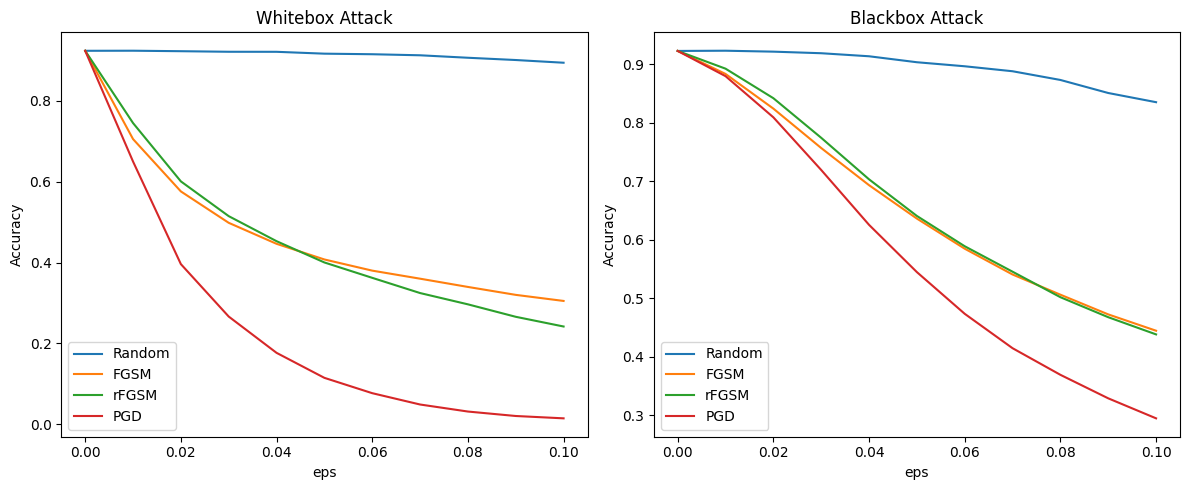

In [ ]:
figure, axis = plot_lab2_white_black(epsilon_arr=EPS_list_lab2, white_acc_d=white_acc_dict, black_acc_d=black_acc_dict, 
                             label_names=lab2_label)
plt.show()

## Train Robust Models, Lab 3 a/b

Plotting accuracy vs epochs.

In [13]:
def lab3_ab_return_adv_data(model, device, dat, lbl, eps, alpha, iters, rand_start, which_method):
    if which_method == 'FGSM':
        return attacks.FGSM_attack(model, device, dat, lbl, eps)[0]
    elif which_method == 'rFGSM':
        return attacks.rFGSM_attack(model, device, dat, lbl, eps)[0]
    elif which_method == 'PGD':
        return attacks.PGD_attack(model, device, dat, lbl, eps, alpha, iters, rand_start)[0]
    else:
        raise KeyError


def plot_lab3_epoch_vs_test_acc(n_epochs, in_dict, which_part, save=False):
    fig, ax = plt.subplots(1, 1)
    ax.plot(range(n_epochs), in_dict[which_part][2], label='Last Test Acc (clean data) %.4f' % in_dict[which_part][2][-1])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Adversarial Training (%s attack)' % in_dict[which_part][0])
    ax.legend()

    fig.tight_layout()
    if save:
        plt.savefig('Figures/lab3_%s_%s.pdf' % (which_part, in_dict[which_part][0]), dpi=500, bbox_inches='tight')
    # save name example: Figures/lab3_a1_FSGM.pdf
    return fig, ax

In [ ]:
## lab 3 version of the training code
lab3_parts = ['a1', 'a2', 'b']

lab3_adv_training = {'a1': ['FGSM', 'netA_advtrain_fgsm0p1.pt', []], 
                    'a2': ['rFGSM', 'netA_advtrain_rfgsm0p1.pt', []], 
                    'b': ['PGD', 'netA_advtrain_pgd0p1.pt', []]}
for lab3_part in lab3_parts:
    # lab3_adv_training stores name of attack, name of saved model, and test_acc list
    ATK_EPS = 0.1
    ATK_ITERS = 4  # only for PGD
    ATK_ALPHA = 1.85 * (ATK_EPS/ATK_ITERS)  # only for PGD

    ## Pick a model architecture, picked NetA and train from scratch

    net = models.NetA().to(device)
    ## Checkpoint name for this model
    model_checkpoint = lab3_adv_training[lab3_part][1]
    which_method = lab3_adv_training[lab3_part][0]
    ## Basic training params
    num_epochs = 20
    initial_lr = 0.001
    lr_decay_epoch = 15

    optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

    ## Training Loop
    for epoch in range(num_epochs):
        net.train()
        train_correct = 0.
        train_loss = 0.
        train_total = 0.
        for batch_idx,(data,labels) in enumerate(train_loader):
            data = data.to(device); labels = labels.to(device)

            adv_data = lab3_ab_return_adv_data(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, 
                                               iters=ATK_ITERS, rand_start=True, which_method=which_method)
            # Forward pass
            adv_outputs = net(adv_data)
            net.zero_grad()
            optimizer.zero_grad()
            # Compute loss, gradients, and update params
            loss = F.cross_entropy(adv_outputs, labels)
            loss.backward()
            optimizer.step()
            # Update stats
            _, preds = adv_outputs.max(1)
            train_correct += preds.eq(labels).sum().item()
            train_loss += loss.item()
            train_total += labels.size(0)
            
        # End of training epoch
        test_acc, test_loss = test_model(net, test_loader, device)  # using clean data
        lab3_adv_training[lab3_part][2].append(test_acc)

        print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
            epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
            test_acc, test_loss,
        ))
        # Save model    
        torch.save(net.state_dict(), model_checkpoint)
        
        # Update LR
        if epoch == lr_decay_epoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] = initial_lr*0.1
    
    plot_lab3_epoch_vs_test_acc(n_epochs=num_epochs, in_dict=lab3_adv_training, which_part=lab3_part)

print("Done!")

## Test Robust Models, Lab 3 c/d

Don't forget to plot accuracy vs. epsilon curves!

In [ ]:
def plot_lab3_eps_vs_acc(epsilon_arr, accuracy_dict, label_names_lst, save=False):
    fig, ax = plt.subplots(1, len(label_names_lst), figsize=(16, 5))

    for iii, model_name in enumerate(label_names_lst):
        for jjj, line_name in enumerate(label_names_lst):
            ax[iii].plot(epsilon_arr, accuracy_dict[model_name][line_name], label=line_name)
        ax[iii].set_xlabel('eps')
        ax[iii].set_ylabel('Accuracy')
        ax[iii].set_title('Model Trained with %s Attack' % model_name)
        ax[iii].legend()

    fig.tight_layout()
    if save:
        plt.savefig('Figures/lab3cd_attacks.pdf', dpi=500, bbox_inches='tight')
    return fig, ax


In [ ]:
## lab 3 testing model with adversarial data
EPS_list_lab3cd = np.linspace(0, 0.07, 8) * 2
lab3_labels = ['FGSM', 'rFGSM', 'PGD']
lab3_adv_train_checkpoints = {'FGSM': 'netA_advtrain_fgsm0p1.pt', 
                              'rFGSM': 'netA_advtrain_rfgsm0p1.pt', 
                              'PGD': 'netA_advtrain_pgd0p1.pt'}

# outer label: name of attack that was used to train the model; inner label: name of attack
lab3_acc_dict = {'FGSM': {'FGSM': [], 'rFGSM': [], 'PGD': []}, 
                 'rFGSM': {'FGSM': [], 'rFGSM': [], 'PGD': []}, 
                 'PGD': {'FGSM': [], 'rFGSM': [], 'PGD': []}}

print(EPS_list_lab3cd)
for epsilon in EPS_list_lab3cd:
    print('epsilon', epsilon)
    for which_model in lab3_labels:  # select model using dict in cell above
        model_checkpoint = lab3_adv_train_checkpoints[which_model]  # name of checkpoint
        # which method was used to train the model, can be "rFGSM, FGSM, PGD"
        print('    which method used to train model', which_model)
        whitebox = models.NetA()
        whitebox.load_state_dict(torch.load(model_checkpoint)) # TODO: Load your robust models
        whitebox = whitebox.to(device)
        whitebox.eval(); 

        test_acc, _ = test_model(whitebox, test_loader, device)
        print("    Initial Accuracy of Whitebox Model: ", test_acc)

        ## Test the model against an adversarial attack

        # TODO: Set attack parameters here
        ATK_EPS = epsilon
        ATK_ITERS = 4
        ATK_ALPHA = 1.85 * (ATK_EPS/ATK_ITERS)
        for which_attack in lab3_labels:
            print('        which attack', which_attack)
            whitebox_correct = 0.
            running_total = 0.
            for batch_idx, (data, labels) in enumerate(test_loader):
                data = data.to(device) 
                labels = labels.to(device)

                # TODO: Perform adversarial attack here
                adv_data = lab3_ab_return_adv_data(model=whitebox, device=device, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, 
                                                   iters=ATK_ITERS, rand_start=True, which_method=which_attack)
                # Sanity checking if adversarial example is "legal"
                assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
                assert(adv_data.max() == 1.)
                assert(adv_data.min() == 0.)
                
                # Compute accuracy on perturbed data
                with torch.no_grad():
                    whitebox_outputs = whitebox(adv_data)
                    _,whitebox_preds = whitebox_outputs.max(1)
                    whitebox_correct += whitebox_preds.eq(labels).sum().item()
                    running_total += labels.size(0)
                
                # Plot some samples
                # if batch_idx == 1:
                #     plt.figure(figsize=(15,5))
                #     for jj in range(12):
                #         plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
                #     plt.tight_layout()
                #     plt.show()
            # Print final 
            whitebox_acc = whitebox_correct/running_total
            lab3_acc_dict[which_model][which_attack].append(whitebox_acc)
            print("        Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

        print("    Done with this model!")
    print("Done with this epsilon!")

(<Figure size 1600x500 with 3 Axes>,
 array([<Axes: title={'center': 'Model Trained with FGSM Attack'}, xlabel='eps', ylabel='Accuracy'>,
        <Axes: title={'center': 'Model Trained with rFGSM Attack'}, xlabel='eps', ylabel='Accuracy'>,
        <Axes: title={'center': 'Model Trained with PGD Attack'}, xlabel='eps', ylabel='Accuracy'>],
       dtype=object))

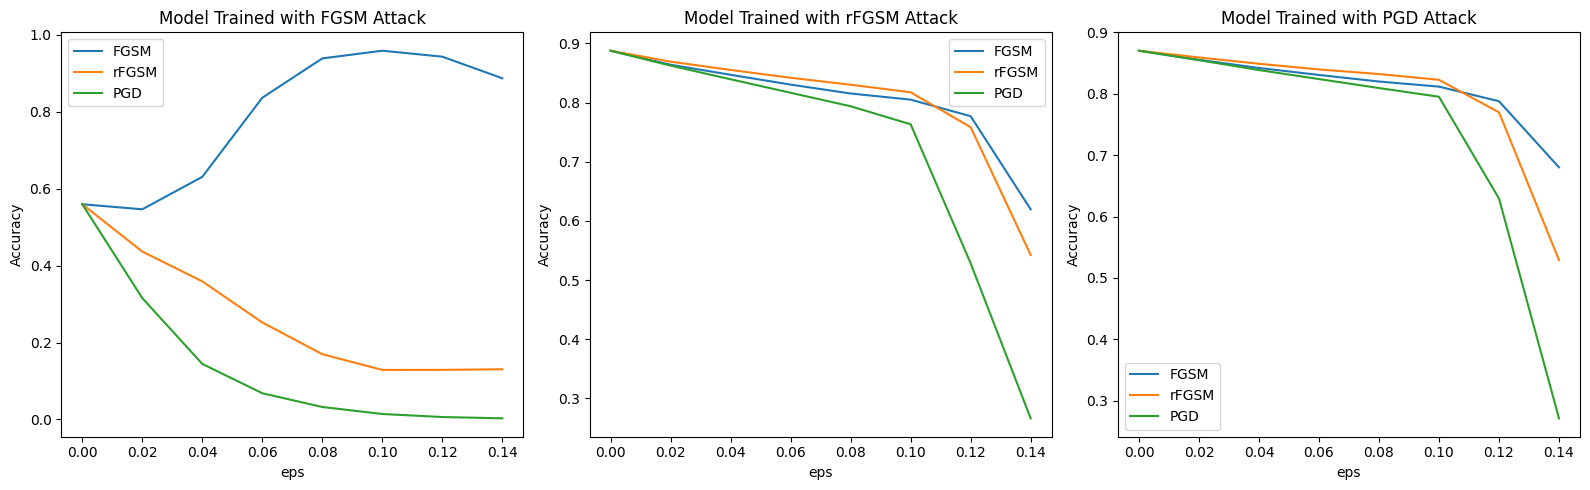

In [ ]:
_, _ = plot_lab3_eps_vs_acc(epsilon_arr=EPS_list_lab3cd, accuracy_dict=lab3_acc_dict, label_names_lst=lab3_labels, save=True)

## Lab-3e Bonus (train models using PGD AT with different epsilon)


In [ ]:
def plot_lab3_bonus_epoch_vs_test_acc(n_epochs, in_dict, eps_list, save=False):
    ## in_dict now maps eps to test_acc_arr
    fig, ax = plt.subplots(1, 1)
    for iii, eps in enumerate(eps_list):
        ax.plot(range(n_epochs), in_dict[eps], label='eps=%g, Last Test Acc (clean data) %.4f' % (eps, in_dict[eps][-1]))
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Adversarial Training (PGD attack) for Different eps')
    ax.legend()
    fig.tight_layout()
    if save:
        plt.savefig('Figures/lab3e_testAcc.pdf', dpi=500, bbox_inches='tight')
    return fig, ax

In [11]:
## lab 3 bonus version of the training code, part (e)
eps_lab3_bonus = [0.05, 0.2, 0.4]
lab3_bonus_AT_dict = {eps_val: [] for eps_val in eps_lab3_bonus}
## Basic training params

num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

for epsilon in eps_lab3_bonus:
    print('epsilon', epsilon)
    # lab3_adv_training stores name of attack, name of saved model, and test_acc list
    ATK_EPS = epsilon
    ATK_ITERS = 4  # only for PGD
    ATK_ALPHA = 1.85 * (ATK_EPS/ATK_ITERS)  # only for PGD

    ## Pick a model architecture, picked NetA and train from scratch

    net = models.NetA().to(device)
    ## Checkpoint name for this model
    model_checkpoint = 'netA_advtrain_pgd_eps_%g.pt' % epsilon

    optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

    ## Training Loop
    for epoch in range(num_epochs):
        net.train()
        train_correct = 0.
        train_loss = 0.
        train_total = 0.
        for batch_idx,(data,labels) in enumerate(train_loader):
            data = data.to(device); labels = labels.to(device)

            adv_data = attacks.PGD_attack(model=net, device=device, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, 
                                          iters=ATK_ITERS, rand_start=True)[0]
            # Forward pass
            adv_outputs = net(adv_data)
            net.zero_grad()
            optimizer.zero_grad()
            # Compute loss, gradients, and update params
            loss = F.cross_entropy(adv_outputs, labels)
            loss.backward()
            optimizer.step()
            # Update stats
            _, preds = adv_outputs.max(1)
            train_correct += preds.eq(labels).sum().item()
            train_loss += loss.item()
            train_total += labels.size(0)
            
        # End of training epoch
        test_acc, test_loss = test_model(net, test_loader, device)  # using clean data
        lab3_bonus_AT_dict[epsilon].append(test_acc)

        print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
            epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
            test_acc, test_loss,
        ))
        # Save model    
        torch.save(net.state_dict(), model_checkpoint)
        
        # Update LR
        if epoch == lr_decay_epoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] = initial_lr*0.1
    print("Done, epsilon %g", epsilon)
print("Done!")

# write eps vals in to a file
f_ptr = open('lab3_bonus_eps_vals.txt', 'w')
for eps in eps_lab3_bonus:
    f_ptr.write('%g\n' % eps)
f_ptr.close()

epsilon 0.05
Epoch: [ 0 / 20 ]; TrainAcc: 0.72708; TrainLoss: 0.68802; TestAcc: 0.85220; TestLoss: 0.40098
Epoch: [ 1 / 20 ]; TrainAcc: 0.78228; TrainLoss: 0.54115; TestAcc: 0.85700; TestLoss: 0.37188
Epoch: [ 2 / 20 ]; TrainAcc: 0.79663; TrainLoss: 0.50594; TestAcc: 0.86780; TestLoss: 0.35541
Epoch: [ 3 / 20 ]; TrainAcc: 0.80670; TrainLoss: 0.48211; TestAcc: 0.86770; TestLoss: 0.34721
Epoch: [ 4 / 20 ]; TrainAcc: 0.81093; TrainLoss: 0.46610; TestAcc: 0.87300; TestLoss: 0.33636
Epoch: [ 5 / 20 ]; TrainAcc: 0.81782; TrainLoss: 0.45285; TestAcc: 0.87240; TestLoss: 0.33285
Epoch: [ 6 / 20 ]; TrainAcc: 0.82295; TrainLoss: 0.44006; TestAcc: 0.87490; TestLoss: 0.32230
Epoch: [ 7 / 20 ]; TrainAcc: 0.82640; TrainLoss: 0.43019; TestAcc: 0.88120; TestLoss: 0.31535
Epoch: [ 8 / 20 ]; TrainAcc: 0.83055; TrainLoss: 0.41955; TestAcc: 0.88380; TestLoss: 0.31003
Epoch: [ 9 / 20 ]; TrainAcc: 0.83340; TrainLoss: 0.41046; TestAcc: 0.88450; TestLoss: 0.30312
Epoch: [ 10 / 20 ]; TrainAcc: 0.83622; TrainLos

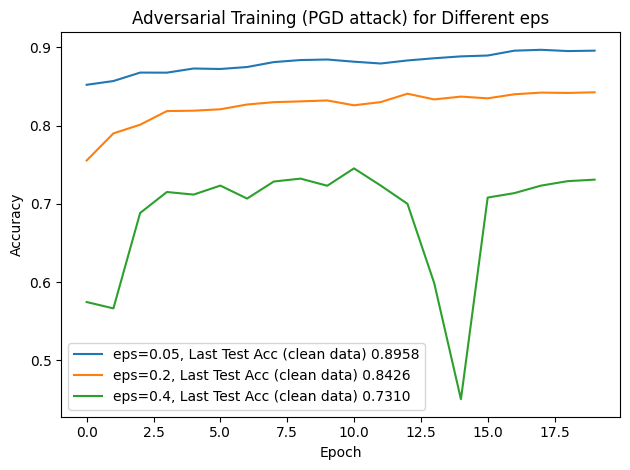

In [12]:
_, _ = plot_lab3_bonus_epoch_vs_test_acc(n_epochs=num_epochs, in_dict=lab3_bonus_AT_dict, eps_list=eps_lab3_bonus, save=True)

In [29]:
def plot_lab3_bonus_eps_vs_acc(epsilon_arr, accuracy_dict, attack_list, save=False):
    fig, ax = plt.subplots(1, len(accuracy_dict.keys()), figsize=(16, 5))

    for iii, model_eps in enumerate(accuracy_dict):
        for jjj, attack_name in enumerate(attack_list):
            ax[iii].plot(epsilon_arr, accuracy_dict[model_eps][attack_name], label='%s attack' % attack_name)
        ax[iii].set_xlabel('eps')
        ax[iii].set_ylabel('Accuracy')
        ax[iii].set_title('Model Trained with PGD Attack, model_eps=%g' % model_eps)
        ax[iii].legend()

    fig.tight_layout()
    if save:
        plt.savefig('Figures/lab3e_acc_vs_eps.pdf', dpi=500, bbox_inches='tight')
    return fig, ax

In [ ]:
## lab 3 testing model with adversarial data
lines = open('lab3_bonus_eps_vals.txt', 'r').readlines()

eps_lst_from_file = [float(line) for line in lines]

EPS_list_lab3_bonus = np.linspace(0, 0.44, 23)
lab3_bonus_checkpoint_base = 'netA_advtrain_pgd_eps_'

# outer label: name of attack that was used to train the model; inner label: name of attack
attack_list_lab3_bonus = ['FGSM', 'rFGSM', 'PGD']
lab3_bonus_attack_acc_dict = {eps: {at: [] for at in attack_list_lab3_bonus} for eps in eps_lst_from_file}

print(EPS_list_lab3_bonus)
for epsilon in EPS_list_lab3_bonus:  # attack EPS
    print('attack epsilon', epsilon)
    for model_eps in eps_lst_from_file:  # EPS used to train model
        model_checkpoint = lab3_bonus_checkpoint_base + '%g.pt' % model_eps  # name of checkpoint

        print('    which eps used to train model', model_eps)
        whitebox = models.NetA()
        whitebox.load_state_dict(torch.load(model_checkpoint)) # TODO: Load your robust models
        whitebox = whitebox.to(device)
        whitebox.eval(); 

        test_acc, _ = test_model(whitebox, test_loader, device)
        print("    Initial Accuracy of Whitebox Model: ", test_acc)

        ## Test the model against an adversarial attack

        # TODO: Set attack parameters here
        ATK_EPS = epsilon
        ATK_ITERS = 4
        ATK_ALPHA = 1.85 * (ATK_EPS/ATK_ITERS)
        for which_attack in attack_list_lab3_bonus:
            print('        which attack', which_attack)
            whitebox_correct = 0.
            running_total = 0.
            for batch_idx, (data, labels) in enumerate(test_loader):
                data = data.to(device) 
                labels = labels.to(device)

                # TODO: Perform adversarial attack here
                adv_data = lab3_ab_return_adv_data(model=whitebox, device=device, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, 
                                                   iters=ATK_ITERS, rand_start=True, which_method=which_attack)
                # Sanity checking if adversarial example is "legal"
                assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
                assert(adv_data.max() == 1.)
                assert(adv_data.min() == 0.)
                
                # Compute accuracy on perturbed data
                with torch.no_grad():
                    whitebox_outputs = whitebox(adv_data)
                    _,whitebox_preds = whitebox_outputs.max(1)
                    whitebox_correct += whitebox_preds.eq(labels).sum().item()
                    running_total += labels.size(0)
            # Print final 
            whitebox_acc = whitebox_correct/running_total
            lab3_bonus_attack_acc_dict[model_eps][which_attack].append(whitebox_acc)
            print("        Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

        print("    Done with this model!")
    print("Done with this epsilon!")

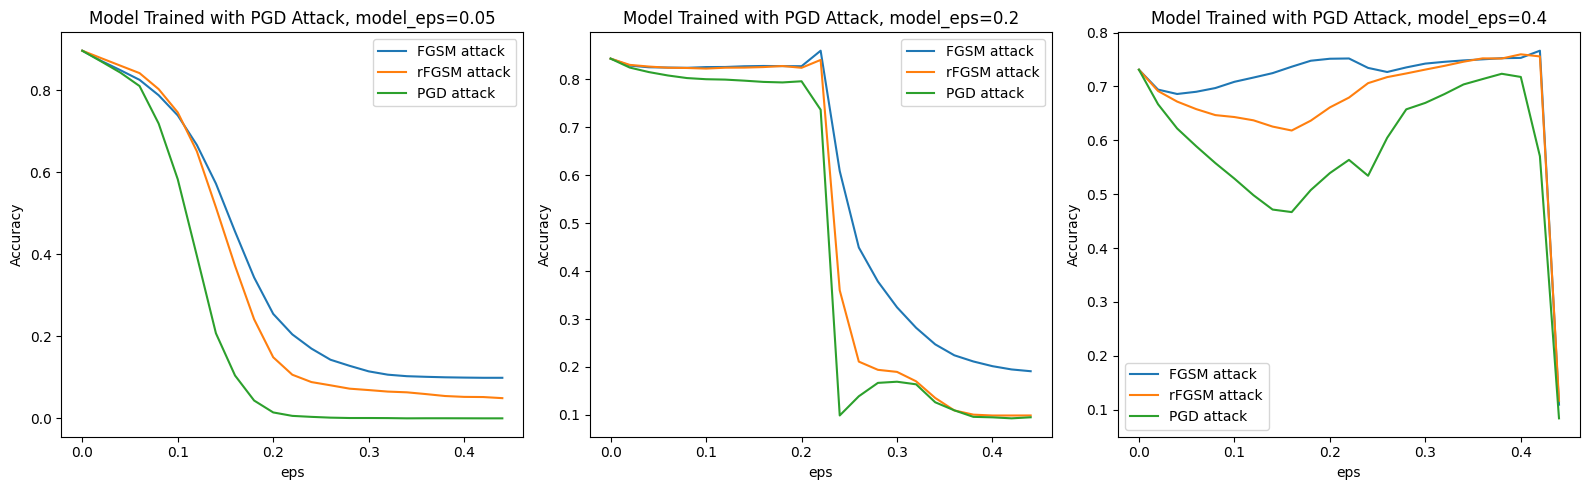

In [31]:
_, _ = plot_lab3_bonus_eps_vs_acc(epsilon_arr=EPS_list_lab3_bonus, accuracy_dict=lab3_bonus_attack_acc_dict, 
                                  attack_list=attack_list_lab3_bonus, save=True)

## Lab-3f, saliency maps (non-AT and PGD-AT models)

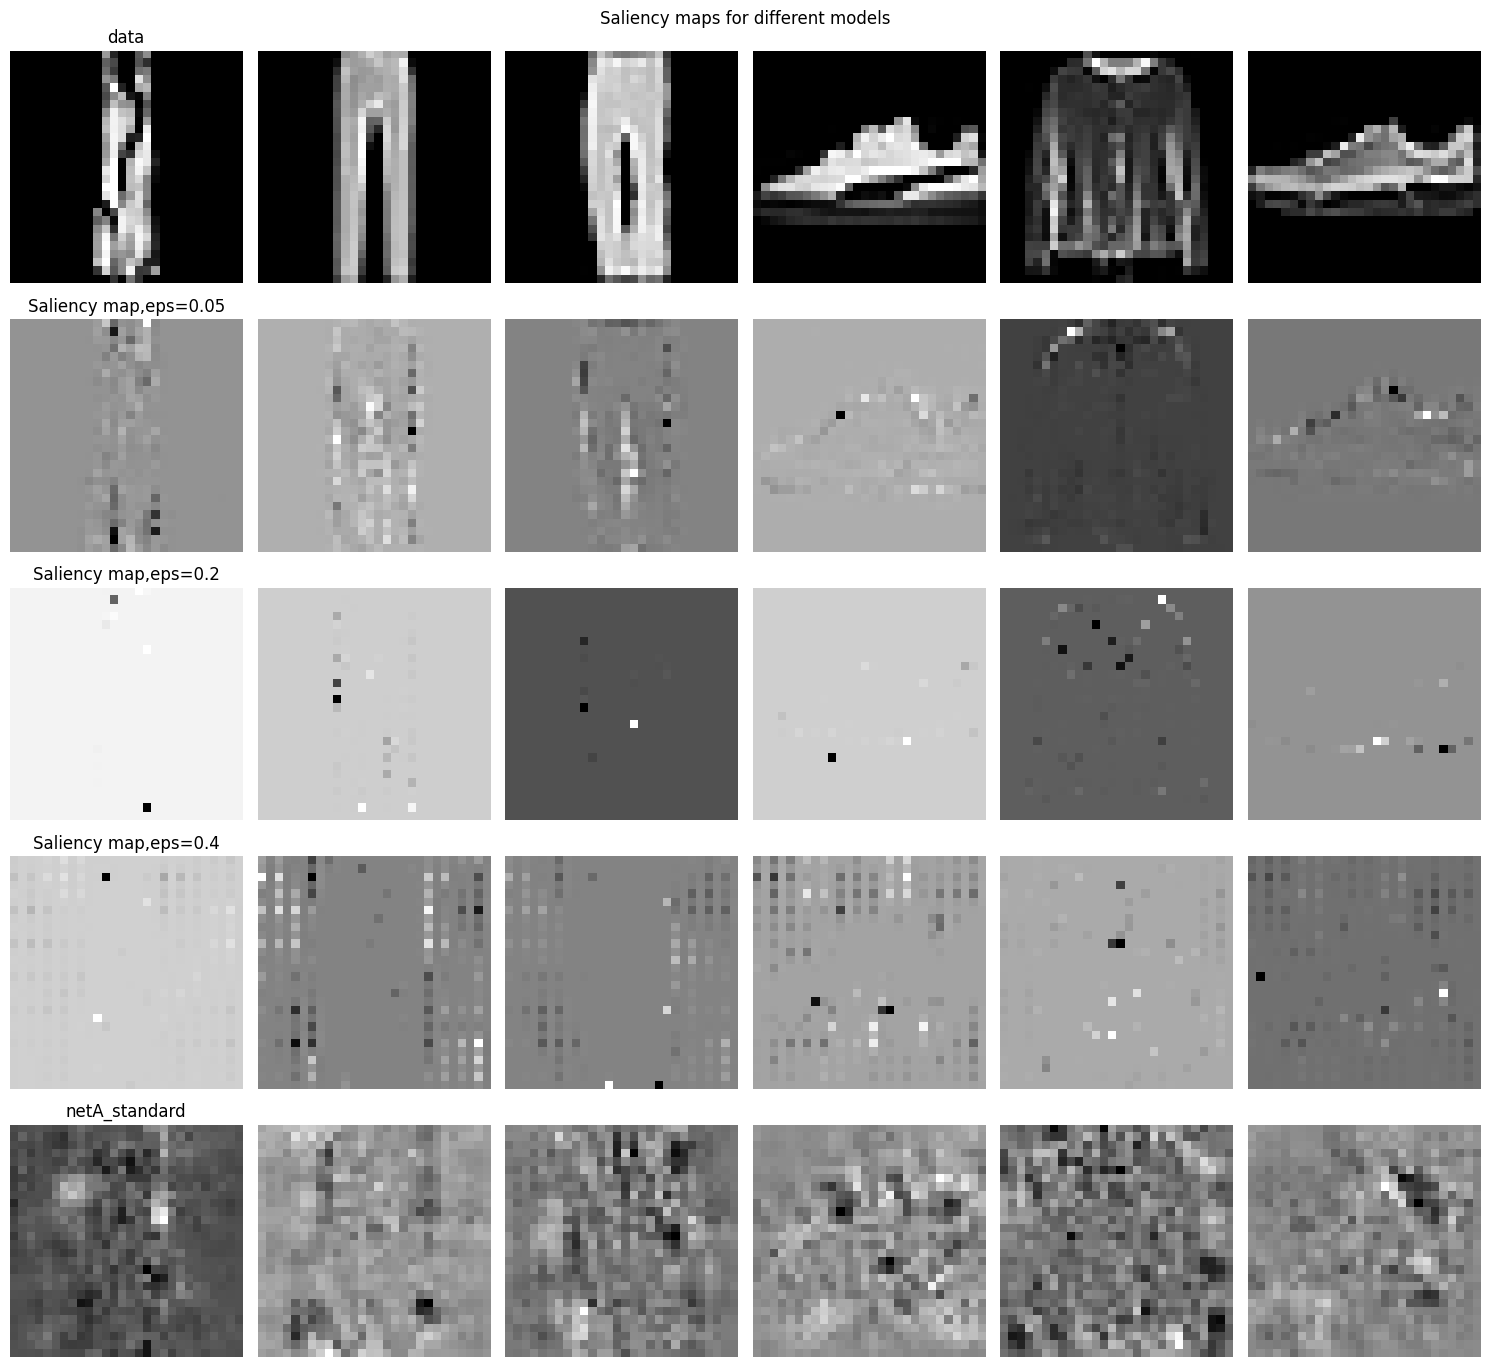

In [30]:
def plot_lab3_bonus_saliency(save=False):
    f_ptr = open('lab3_bonus_eps_vals.txt', 'r')
    lines = f_ptr.readlines()
    f_ptr.close()
    eps_lst_from_file = [float(line) for line in lines]
    model_checkpoints = {'netA_advtrain_pgd_eps_%g.pt' % eps: eps for eps in eps_lst_from_file}
    model_checkpoints['netA_standard.pt'] = -1
    num_examples = 6
    inds = 0
    for data, _ in test_loader:
        inds = random.sample(list(range(data.size(0))), num_examples)  # which data points in batch to plot
        break
    fig, ax = plt.subplots(4 + 1, num_examples, figsize=(15, 14))
    for jj in range(num_examples):
        ax[0, jj].imshow(data[inds[jj], 0].cpu().numpy(), cmap='gray', interpolation='none')
        ax[0, jj].axis("off")
        if jj == 0:
            ax[0, jj].set_title('data')
    for i, (model_checkpoint, eps) in enumerate(model_checkpoints.items()):
        whitebox = models.NetA()
        whitebox.load_state_dict(torch.load(model_checkpoint)) # TODO: Load your robust models
        whitebox = whitebox.to(device)
        whitebox.eval(); 
        for batch_idx, (data, labels) in enumerate(test_loader): 
            # plt.figure(figsize=(15, 5))
            data, labels = data.to(device), labels.to(device)
            grad_wrt_data = attacks.gradient_wrt_data(whitebox, device, data, lbl=labels)
            
            for jj in range(num_examples):
                ax[i+1, jj].imshow(grad_wrt_data[inds[jj], 0].cpu().numpy(), cmap='gray', interpolation='none')
                ax[i+1, jj].axis("off")
                # plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
                if jj == 0:
                    ax[i+1, jj].set_title('Saliency map,eps=%g' % eps)
                    if eps == -1:
                        ax[i+1, jj].set_title('netA_standard')
            
            break
    fig.suptitle("Saliency maps for different models")
    fig.tight_layout()
    if save:
        plt.savefig('Figures/lab3f_saliency.pdf', dpi=500, bbox_inches='tight')
    return


plot_lab3_bonus_saliency(save=True)